In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import kstest
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from IPython.display import Latex, display

In [2]:
file_path = 'bitcoin_blocks_and_transactions_sorted.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_path,index_col=False)
num_rows = df.shape[0]
print(f"Number of rows using .shape[0]: {num_rows}")

Number of rows using .shape[0]: 15000


In [3]:

"""df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string))"""

'df_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string))'

In [4]:
df.head()



,id,height,version,timestamp,tx_count,size,weight,merkle_root,previousblockhash,mediantime,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,00000000000000000001c827e4d9c2360756e5d76e492b...,862501,603979776,1727084204,2277,1856961,3992901,17d01c5d7b8441565de2ccf4db0e8163403b0899007f07...,00000000000000000002d5b4f115ca2458acb75a13422e...,1727081265,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,862502,738197504,1727084749,2341,1839000,3993360,47ed70e4da0f302114fc572bab062c99c0bbe3070fd315...,00000000000000000001c827e4d9c2360756e5d76e492b...,1727082238,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,00000000000000000001a519c445c0a3f1319630603560...,862503,823279616,1727085461,3137,1645376,3993413,eeff8b0b686006f32aedbe7d4c0eaaa321b6fd73c8c723...,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,1727082320,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,000000000000000000020bce365f1f28bc4d51779fdb02...,862504,536911872,1727086363,3447,1716979,3993739,dc16c1f3d16552542d1a10894dbcc7fda6464ea7f3f055...,00000000000000000001a519c445c0a3f1319630603560...,1727082730,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,000000000000000000020a8002a7488358d0a7313a00c9...,862505,1073676288,1727087094,3360,1741490,3997772,e0450adca29bf1be837896b4ea3c8ad693079529bc80e2...,000000000000000000020bce365f1f28bc4d51779fdb02...,1727083818,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [5]:
columns_to_drop = ['id','height', 'merkle_root','previousblockhash','mediantime']
df = df.drop(columns_to_drop, axis=1)

In [6]:
df.insert(0, 'formatted_timestamp', pd.to_datetime(df['timestamp'],unit='s'))

In [7]:
df= df.sort_values(by='formatted_timestamp', ascending=True)

In [8]:
delay_interval = round(pd.to_datetime(df['timestamp'],unit='s').diff().dt.total_seconds())
df.insert(0, 'delay_interval', delay_interval)

In [9]:

"""
df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string)) """

'\ndf_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string)) '

In [10]:
df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,NaN,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [11]:
df.iat[0, 0] = 0
df['difficulty'] = pd.to_numeric(df['difficulty'], errors='coerce')

In [12]:
"""df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string))"""

'df_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string))'

In [13]:
 df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,0.0,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [14]:
def zscore_safe(a):
    a = np.asarray(a, float)
    m = np.nanmean(a)
    s = np.nanstd(a)
    if not np.isfinite(s) or s == 0:
        # column is constant or degenerate -> use zeros (no signal, no NaNs)
        return np.zeros_like(a)
    return (a - m) / s

In [15]:
x_diff = zscore_safe(df['difficulty'])
x_tx = zscore_safe(df['tx_count'])
x_size = zscore_safe(df['size'])
x_weight = zscore_safe(df['weight'])
#x_input = zscore(df['input_count'])
x_input = zscore_safe(df['input_count'])
x_fees = zscore_safe(df['total_trans_fees'])

In [16]:
times_data = np.cumsum(df['delay_interval']).astype(float)

In [17]:
N=len(times_data) 
N

15000

In [18]:
# Build design matrix (N x 6). Make sure each vector has length N == len(dt)
X = np.column_stack([
    np.asarray(x_diff,  float),
    np.asarray(x_tx,    float)
    #np.asarray(x_size,  float),
    #np.asarray(x_weight,float),
    #np.asarray(x_input, float),
    #np.asarray(x_fees,  float),
])

In [19]:
col_medians = np.nanmedian(X, axis=0)

In [20]:
X = np.where(np.isfinite(X), X, col_medians)

assert np.all(np.isfinite(X))

In [21]:
def make_intervals(times_data):
    t = np.asarray(times_data, float)
    t = t[np.isfinite(t)]
    t = np.sort(t)
    if t.size == 0:
        raise ValueError("No events")

    # gaps: from 0→t0, then between events
    dt = np.empty_like(t)
    dt[0]  = t[0]                 # gap from 0 to first event
    di     = np.diff(t)
    # robust tiny epsilon to avoid zeros/negatives everywhere
    med    = np.median(di[di>0]) if np.any(di>0) else max(t[0], 600.0)
    eps    = max(1e-12, 1e-9*med)
    dt[1:] = np.where(di > 0, di, eps)
    # clip the first gap too (in case t[0]==0)
    dt[0]  = max(dt[0], eps)

    return t, dt, eps

times, dt, eps = make_intervals(times_data)   # <-- use your times_data here
N = dt.size
coords = {"interval": np.arange(N)}

In [22]:
#feat_names = ["diff","tx","size","weight","input","fees"]
feat_names = ["diff","tx"]

# If your coords already exist, just ensure they include the 'feat' axis:
coords = {
    "interval": np.arange(len(dt)),
    "feat": feat_names,
}
p  = X.shape[1]   
with pm.Model(coords={"interval": np.arange(N), "feat": np.arange(p)}) as ip_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    X_c  = pm.Data("X",  X,  dims=["interval","feat"])

    beta0 = pm.Normal("beta0", 0., 1.)
    b     = pm.Normal("b", 0., 1., dims=["feat"])

    lin   = pm.math.clip(beta0 + pm.math.dot(X_c, b), -40, 40)
    lam   = pm.math.exp(lin)
    ll_i  = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    id_ip = pm.sample(1000, tune=1000, chains=4, target_accept=0.9,
                      return_inferencedata=True, init="adapt_diag", random_seed=42)

# Expose pointwise log-lik for ArviZ (idempotent)
try:
    id_ip.add_groups({"log_likelihood": {"interval": id_ip.posterior["ll_interval"]}})
except ValueError:
    # group exists -> just assign/overwrite the variable
    id_ip.log_likelihood["interval"] = id_ip.posterior["ll_interval"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [23]:
X_c.shape

Shape.0

In [24]:
with pm.Model(coords=coords) as pois_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    mu   = pm.HalfNormal("mu", 1.0)
    lam  = pm.math.clip(mu, 1e-12, 1e12)
    ll_i = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())
    id_pois = pm.sample(1000, tune=1000, chains=4, target_accept=0.9,
                        return_inferencedata=True, init="adapt_diag", random_seed=42)

# expose pointwise loglik for ArviZ
id_pois.add_groups({"log_likelihood": {"interval": id_pois.posterior["ll_interval"]}})

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [25]:
with pm.Model(coords=coords) as weib_m:
    k     = pm.Exponential("k", 1.0)        # shape > 0
    scale = pm.Exponential("scale", 1.0)    # scale > 0
    y     = pm.Weibull("y", alpha=k, beta=scale, observed=dt, dims=["interval"])
    id_weib = pm.sample(1000, tune=1000, chains=4, target_accept=0.95,
                        return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

id_weib.log_likelihood["interval"] = id_weib.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [26]:
with pm.Model(coords=coords) as gam_m:
    # use built-in likelihood so ArviZ records ll per obs automatically
    k    = pm.Exponential("k", 1.0)         # shape > 0
    rate = pm.Exponential("rate", 1.0)      # rate > 0  (1/scale)
    y    = pm.Gamma("y", alpha=k, beta=rate, observed=dt, dims=["interval"])
    id_gamma = pm.sample(1000, tune=1000, chains=4, target_accept=0.95,
                         return_inferencedata=True, init="adapt_diag", idata_kwargs={"log_likelihood": True}, random_seed=42)

# alias to a common name
id_gamma.log_likelihood["interval"] = id_gamma.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [27]:
import pytensor.tensor as pt
from pytensor.scan.basic import scan

def hawkes_ll_interval_pt(dt, mu, alpha, beta, eps=1e-12):
    dt = pt.as_tensor_variable(dt)
    mu    = pt.clip(mu, eps, 1e12)
    alpha = pt.clip(alpha, eps, 1e12)
    beta  = pt.clip(beta, eps, 1e12)

    def step(dti, s_prev, mu, alpha, beta):
        s_i   = pt.exp(-beta*dti) * (s_prev + 1.0)
        lam_i = mu + alpha*s_i
        log_term = pt.log(pt.clip(lam_i, eps, 1e12))
        integ    = mu*dti + (alpha/beta) * s_prev * (1.0 - pt.exp(-beta*dti))
        return s_i, (log_term - integ)

    (s_seq, contrib_seq), _ = scan(
        fn=step,
        sequences=[dt],
        outputs_info=[pt.as_tensor_variable(0.0).astype(dt.dtype), None],
        non_sequences=[mu, alpha, beta],
    )
    return contrib_seq

with pm.Model(coords=coords) as hawkes_m:
    dt_c  = pm.Data("dt", dt, dims=["interval"])
    mu    = pm.HalfNormal("mu", 1.0)
    beta  = pm.HalfNormal("beta", 1.0)
    rho   = pm.Beta("rho", 2, 5)
    alpha = pm.Deterministic("alpha", rho*beta)

    # optional soft stationarity constraint (alpha/beta < 1)
    pm.Potential("stability", pm.math.switch(alpha/beta < 0.98, 0.0, -np.inf))

    ll_i = hawkes_ll_interval_pt(dt_c, mu, alpha, beta)
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    # Use Metropolis for robustness (no gradients through scan)
    id_hawkes = pm.sample(1000, tune=1000, chains=4, step=pm.Metropolis(),
                          return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

#id_hawkes.log_likelihood["interval"] = id_hawkes.posterior["ll_interval"]
id_hawkes.add_groups({"log_likelihood": {"interval": id_hawkes.posterior["ll_interval"]}})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [beta]
>Metropolis: [rho]


Output()

/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 964 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [28]:
def show_shape(name, idata):
    ll = idata.log_likelihood["interval"]
    print(name, ll.dims, ll.shape)

for nm, idt in [("pois", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                ("weibull", id_weib), ("hawkes", id_hawkes)]:
    show_shape(nm, idt)

pois ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)
ip ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)
gamma ('chain', 'draw', 'interval') (4, 1000, 15000)
weibull ('chain', 'draw', 'interval') (4, 1000, 15000)
hawkes ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)


In [29]:
import arviz as az
cmp = az.compare(
    {"poisson": id_pois, "ip": id_ip, "gamma": id_gamma, "weibull": id_weib, "hawkes": id_hawkes},
    ic="loo", method="stacking", var_name="interval"
)
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-104990.719336,1.274078,0.000000,1.000000e+00,152.942897,0.000000,False,log
ip,1,-110481.544652,2.967393,5490.825315,2.650954e-07,120.776248,68.741589,False,log
gamma,2,-110508.965823,2.000011,5518.246486,7.278911e-07,120.079164,72.484117,False,log
poisson,3,-110519.971158,0.955678,5529.251821,5.202841e-20,119.912244,68.901498,False,log
weibull,4,-110522.424197,1.883905,5531.704861,0.000000e+00,124.495296,70.139477,False,log


In [30]:
import numpy as np

# Choose your tail threshold (seconds)
tau = 600.0  # e.g., 10 minutes

times = np.asarray(times_data, float)
times = np.sort(times)             # just to be safe

# raw gaps (N-1)
dt_all = np.diff(times)

print(f"Δt count={dt_all.size}, tail(>={tau})={np.sum(dt_all>tau)}")

Δt count=14999, tail(>=600.0)=5348


In [31]:
def tail_mask_from_idata(idata, times, tau, prefer="interval", ignore_first_if_needed=True):
    """
    Returns: mask (bool array length = last dim of the model's log_likelihood),
             var_name used, and the last-dimension name.
    """
    # pick the log_likelihood var name
    if hasattr(idata, "log_likelihood"):
        if prefer in idata.log_likelihood.data_vars:
            vname = prefer
        else:
            # fallback: first available
            vname = list(idata.log_likelihood.data_vars)[0]
    else:
        raise ValueError("This InferenceData has no log_likelihood group.")

    ll = idata.log_likelihood[vname]
    obs_dim = ll.dims[-1]
    M = ll.sizes[obs_dim]              # number of pointwise terms stored

    times = np.asarray(times, float)
    N = len(times)

    # Build a dt vector that matches M
    if M == N - 1:
        dt_for_ll = np.diff(times)             # standard inter-arrivals
    elif M == N:
        # some Hawkes/Poisson impls stored a length-N vector (including a 'leading' term)
        dt_for_ll = np.r_[times[0], np.diff(times)]
        if ignore_first_if_needed and M == N:
            # If you decide the 'leading' pseudo-gap shouldn't be considered tail:
            dt_for_ll = dt_for_ll.copy()
            dt_for_ll[0] = -np.inf  # ensure it's not selected as tail
    else:
        raise ValueError(f"Can't align: ll length {M} vs times length {N}")

    mask = dt_for_ll > tau
    return mask, vname, obs_dim

In [32]:
from scipy.special import logsumexp

def tail_log_score(idata, times, tau, prefer="interval"):
    mask, vname, obs_dim = tail_mask_from_idata(idata, times, tau, prefer=prefer)
    ll = idata.log_likelihood[vname]                     # (chain, draw, obs)
    arr = np.asarray(ll)                                 # to ndarray
    C, D, M = arr.shape
    S = C * D
    arr2 = arr.reshape(S, M)                             # (samples, obs)

    idx = np.where(mask)[0]
    if idx.size == 0:
        raise ValueError("No tail observations under this τ; choose a smaller τ.")

    # log p(y_i) ≈ logsumexp over samples - log(S)
    lp_i = logsumexp(arr2[:, idx], axis=0) - np.log(S)   # per-tail-obs log score
    return float(lp_i.sum()), lp_i, idx

# Run it for each model
scores = {}
details = {}
for name, idt in [("poisson", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                  ("weibull", id_weib), ("hawkes", id_hawkes)]:
    s, lp_i, idx = tail_log_score(idt, times, tau)
    scores[name]  = s
    details[name] = (lp_i, idx)

print("Tail-only total log scores (higher is better):")
for k,v in sorted(scores.items(), key=lambda kv: -kv[1]):
    print(f"{k:8s}: {v:,.2f}")

Tail-only total log scores (higher is better):
hawkes  : -44,510.88
gamma   : -44,786.47
poisson : -44,827.67
ip      : -44,833.83
weibull : -44,996.57


In [33]:
lp_h, idx = details["hawkes"][0], details["hawkes"][1]
lp_p      = details["poisson"][0]   # same idx order by construction
diff_hp   = lp_h - lp_p
print("Median per-tail log-score advantage (Hawkes - Poisson):", np.median(diff_hp))

Median per-tail log-score advantage (Hawkes - Poisson): 0.08026968619832076


In [34]:
import arviz as az
import xarray as xr

def tail_loo(idata, times, tau, prefer="interval"):
    mask, vname, obs_dim = tail_mask_from_idata(idata, times, tau, prefer=prefer)
    idx = np.where(mask)[0]
    if idx.size == 0:
        raise ValueError("No tail observations under this τ; choose a smaller τ.")

    # Copy and subset ONLY the log_likelihood group
    id2 = idata.copy()
    ll_full = id2.log_likelihood[vname]
    ll_tail = ll_full.isel({obs_dim: idx})

    # replace the whole group with the sliced dataset (keeps chain/draw intact)
    id2.log_likelihood = xr.Dataset({vname: ll_tail})

    # LOO on the restricted set
    return az.loo(id2, var_name=vname, pointwise=True)

# Example: compute tail LOO for all models
loos_tail = {}
for name, idt in [("poisson", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                  ("weibull", id_weib), ("hawkes", id_hawkes)]:
    loos_tail[name] = tail_loo(idt, times, tau)

loos_tail

{'poisson': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44828.37    70.81
 p_loo        0.70        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.70]   (good)     5348  100.0%
    (0.70, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 'ip': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44835.62    71.12
 p_loo        1.79        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.70]   (good)     5348  100.0%
    (0.70, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 'gamma': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44787.45    73.01
 p_loo        0.98        -
 ------
 
 Pareto k diagnostic values:
                          Cou

In [35]:
cmp_tail = az.compare(
    {k: v for k,v in loos_tail.items()}, ic="loo", method="stacking", scale="log"
)
cmp_tail

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-44511.384778,0.508438,0.000000,6.973383e-01,52.492850,0.000000,False,log
gamma,1,-44787.448431,0.976563,276.063653,3.026617e-01,73.012096,38.582005,False,log
poisson,2,-44828.369100,0.698497,316.984322,3.645912e-09,70.808481,36.982971,False,log
ip,3,-44835.621348,1.791159,324.236570,3.772965e-09,71.121805,37.462062,False,log
weibull,4,-44997.696538,1.124946,486.311760,0.000000e+00,75.055451,40.089662,False,log


In [36]:
import re
import numpy as np

def _flatten_draws(da):
    arr = np.asarray(da)
    if arr.ndim == 2:        # (chain, draw)
        return arr.reshape(-1)
    elif arr.ndim >= 3:      # (chain, draw, ...)
        return arr.reshape(arr.shape[0]*arr.shape[1], *arr.shape[2:])
    else:
        return arr

def _detect_ip_params(id_ip, x_future):
    post = id_ip.posterior
    names = list(post.data_vars)

    # try common names
    beta0_name = next((n for n in ("beta0","intercept","const","b0","alpha0") if n in names), None)
    b_name     = next((n for n in ("b","beta","w","coef","coefs","x_diff","x_tx") if n in names), None)

    p = len(x_future)

    # if a vector param with feat dim exists, prefer it
    for n in names:
        da = post[n]
        if "feat" in da.dims and da.sizes["feat"] == p:
            b_name = n
            break

    # if still not found, look for any param whose last dim == p
    if b_name is None:
        for n in names:
            da = post[n]
            last_dim = da.dims[-1] if da.ndim >= 3 else None
            if last_dim and da.sizes[last_dim] == p:
                b_name = n
                break

    # if STILL not found and p==1, allow scalar b
    if b_name is None and p == 1:
        # pick any scalar var (chain, draw) that looks like a slope
        scalars = [n for n in names if (post[n].ndim == 2 and not n.endswith("_log__"))]
        if scalars:
            b_name = scalars[0]

    return b_name, beta0_name

def ip_exceed(id_ip, X_future_row, taus):
    """Return P(Δt > τ | posterior) for an inhomogeneous Poisson (IP) model."""
    x = np.asarray(X_future_row, float)
    x = np.where(np.isfinite(x), x, 0.0)  # fill NaNs with 0 (inputs are z-scored)
    p = x.shape[0]

    post = id_ip.posterior
    b_name, beta0_name = _detect_ip_params(id_ip, x)
    if b_name is None:
        raise RuntimeError("Could not find a coefficient vector in id_ip.posterior")

    # coefficients
    b_da = post[b_name]
    if "feat" in b_da.dims:  # (chain, draw, feat)
        b = b_da.transpose("chain","draw","feat").values.reshape(-1, p)
    elif b_da.ndim >= 3:     # (chain, draw, something) with last dim == p
        b = b_da.transpose("chain","draw", b_da.dims[-1]).values.reshape(-1, p)
    elif b_da.ndim == 2 and p == 1:  # scalar slope, 1-feature model
        b = b_da.values.reshape(-1, 1)
    else:
        raise RuntimeError(f"Param '{b_name}' has unexpected shape {b_da.shape} for p={p}")

    # intercept (optional)
    if beta0_name is not None:
        beta0 = _flatten_draws(post[beta0_name])  # (ndraws,)
    else:
        beta0 = np.zeros(b.shape[0], dtype=float)

    # check alignment
    if beta0.shape[0] != b.shape[0]:
        # trim to common ndraws if needed (rare but can happen if groups differ)
        nd = min(beta0.shape[0], b.shape[0])
        beta0 = beta0[:nd]
        b     = b[:nd, :]

    # λ = exp(beta0 + x·b)
    lin = beta0 + b @ x
    lam = np.exp(np.clip(lin, -40, 40))  # (ndraws,)

    taus = np.asarray(taus, float)
    return np.array([np.mean(np.exp(-lam * t)) for t in taus])

# --- example usage ---
# choose a covariate row with no NaNs; replace with your choice
X_no_nan = X[np.all(np.isfinite(X), axis=1)]
X_future = X_no_nan[-1] if len(X_no_nan) else np.nan_to_num(X[-1], nan=0.0)

taus = [600, 900, 1200]
ex_ip = ip_exceed(id_ip, X_future, taus)
print("IP tail exceedance P(Δt>τ):", dict(zip(taus, ex_ip)))

IP tail exceedance P(Δt>τ): {600: 0.4082420501689126, 900: 0.260873606741964, 1200: 0.16671635235016607}


In [37]:
def peek_posterior_vars(idata):
    print("Posterior vars (name, dims, shape):")
    for k in idata.posterior.data_vars:
        da = idata.posterior[k]
        print(f"  {k:20s}  {tuple(da.dims)}  {tuple(da.shape)}")

peek_posterior_vars(id_ip)

Posterior vars (name, dims, shape):
  beta0                 ('chain', 'draw')  (4, 1000)
  b                     ('chain', 'draw', 'feat')  (4, 1000, 2)
  ll_interval           ('chain', 'draw', 'interval')  (4, 1000, 15000)


In [38]:
import numpy as np
from scipy.special import gammaincc  # regularized upper gamma
import arviz as az

taus = np.array([600, 900, 1200], float)

# --- helpers to pull draws no matter how variables were named ---
def _get_any(idata, candidates):
    post = idata.posterior
    for name in candidates:
        if name in post:
            return np.asarray(post[name]).reshape(-1)  # flatten chain,draw
    return None

def poisson_exceed(id_pois, taus):
    mu = _get_any(id_pois, ["mu", "lam", "lambda"])
    assert mu is not None
    # P(Δt > τ | μ) = exp(-μ τ)
    return np.array([np.mean(np.exp(-mu * t)) for t in taus])

def gamma_exceed(id_gamma, taus):
    k    = _get_any(id_gamma, ["k", "alpha", "shape"])
    rate = _get_any(id_gamma, ["rate", "beta"])  # PyMC Gamma(alpha=k, beta=rate)
    assert k is not None and rate is not None
    # Survival = Q(k, rate*τ) = gammaincc(k, rate*τ)
    return np.array([np.mean(gammaincc(k, rate*t)) for t in taus])

def weibull_exceed(id_weib, taus):
    k     = _get_any(id_weib, ["k", "alpha", "shape"])
    scale = _get_any(id_weib, ["lam", "lambda", "beta", "scale"])
    assert k is not None and scale is not None
    # Survival = exp(-(τ/scale)^k)
    return np.array([np.mean(np.exp(- (t/scale)**k)) for t in taus])

"""def ip_exceed(id_ip, X_future_row, taus):
    # IP: λ = exp(β0 + X·b). You choose the covariates for "next gap" (e.g., last row).
    beta0 = _get_any(id_ip, ["beta0", "intercept"])
    b     = _get_any(id_ip, ["b", "beta", "w","b_diff","b_tx"])
    assert beta0 is not None and b is not None
    p = b.size // 1   # number of features; assume b is [n_draws, p] flattened
    b = b.reshape(-1, p)
    lin = beta0 + b.dot(np.asarray(X_future_row, float))
    lam = np.exp(np.clip(lin, -40, 40))
    return np.array([np.mean(np.exp(-lam * t)) for t in taus])"""

# --- Hawkes (simulate next gap via thinning; conditional on history) ---
def hawkes_nextgap_exceed(id_hawkes, times_data, taus, n_sims_per_draw=50, max_propose=10000, seed=123):
    rng = np.random.default_rng(seed)
    mu   = _get_any(id_hawkes, ["mu"])
    beta = _get_any(id_hawkes, ["beta"])
    alpha= _get_any(id_hawkes, ["alpha"])
    rho  = _get_any(id_hawkes, ["rho"])
    assert (mu is not None) and (beta is not None) and (alpha is not None or rho is not None)
    if alpha is None:
        # some fits store rho and beta; alpha = rho*beta
        alpha = rho * beta

    times = np.asarray(times_data, float)
    dt    = np.diff(times)
    N     = dt.size

    def s_last_post(beta_val):
        # s_{i} recursion after event i : s_i = e^{-β Δt_i} (1 + s_{i-1}), s_0=0
        s = 0.0
        for d in dt:
            s = np.exp(-beta_val * d) * (1.0 + s)
        return s

    def next_gap_sim(mu_val, alpha_val, beta_val, s0, rng):
        # intensity(t) = mu + alpha * s0 * exp(-beta t), decreasing in t
        # Ogata thinning for monotone decreasing: propose from Exp(M), M = current intensity
        t = 0.0
        M = mu_val + alpha_val * s0
        if M <= 0:
            # degenerate safeguard
            return np.inf
        for _ in range(max_propose):
            w = rng.exponential(1.0 / M)
            t += w
            lam_t = mu_val + alpha_val * s0 * np.exp(-beta_val * t)
            if rng.uniform() * M <= lam_t:
                return t
            # decrease bound to the current (smaller) intensity
            M = lam_t
        return t  # fallback (should not happen with sensible params)

    # Monte Carlo across posterior draws
    res = np.zeros_like(taus, dtype=float)
    for j in range(len(mu)):
        s0 = s_last_post(beta[j])
        for _ in range(n_sims_per_draw):
            gap = next_gap_sim(mu[j], alpha[j], beta[j], s0, rng)
            res += (gap > taus).astype(float)
    res /= (len(mu) * n_sims_per_draw)
    return res

# === run (example) ===
taus = np.array([600, 900, 1200], float)
X_future = X[-1]  # e.g., use last covariate row for IP

ex_pois   = poisson_exceed(id_pois, taus)
ex_gamma  = gamma_exceed(id_gamma, taus)
ex_weib   = weibull_exceed(id_weib, taus)
ex_ip     = ip_exceed(id_ip, X_future, taus)
ex_hawkes = hawkes_nextgap_exceed(id_hawkes, times_data, taus, n_sims_per_draw=50)

for name, ex in [("Poisson", ex_pois), ("Gamma", ex_gamma), ("Weibull", ex_weib),
                 ("IP", ex_ip), ("Hawkes", ex_hawkes)]:
    print(name, dict(zip(taus, ex)))

Poisson {600.0: 0.357317623709657, 900.0: 0.21359599583326724, 1200.0: 0.12768486220782008}
Gamma {600.0: 0.36003803766913384, 900.0: 0.2124025460999062, 1200.0: 0.12493627678698678}
Weibull {600.0: 0.3464405176204608, 900.0: 0.2015456572596567, 1200.0: 0.11686342756338476}
IP {600.0: 0.4082420501689126, 900.0: 0.260873606741964, 1200.0: 0.16671635235016607}
Hawkes {600.0: 0.338535, 900.0: 0.245405, 1200.0: 0.18058}


In [39]:
len(X_future)

2

In [40]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.special import gammaincc, gamma as gamma_fn
from scipy.stats import gamma as sp_gamma, weibull_min

# ---------- small utilities ----------
def _get_first(idata, candidates):
    # pick the first var name that exists in posterior
    names = set(idata.posterior.data_vars)
    for n in candidates:
        if n in names:
            return n
    raise KeyError(f"None of {candidates} found. Posterior vars: {sorted(list(names))[:20]}")

def _draws(idata, name):
    """
    Return posterior draws as a NumPy array with chain/draw flattened.

    Shapes:
      (chain, draw)               -> (n_draws,)
      (chain, draw, p)            -> (n_draws, p)
      (chain, draw, p, q, ...)    -> (n_draws, p*q*...)
    """
    arr = np.asarray(idata.posterior[name])  # ensure ndarray
    if arr.ndim == 2:
        # scalar param per draw
        return arr.reshape(-1)
    elif arr.ndim >= 3:
        # vector/matrix param per draw
        n = arr.shape[0] * arr.shape[1]
        rest = int(np.prod(arr.shape[2:], dtype=int))
        return arr.reshape(n, rest)
    else:
        # already (n,) — rare, but handle
        return arr.reshape(-1)

def _bands(S_draws, qs=(5,50,95), axis=0):
    # S_draws: [n_draws, len(tau)]
    return np.percentile(S_draws, qs, axis=axis)   # [3, len(tau)]

def _monotone_decreasing(v):
    # enforce non-increasing (numerical cosmetic)
    return np.maximum.accumulate(v[::-1])[::-1]

# ---------- common inputs ----------
times = np.asarray(times_data, float)
assert np.all(np.diff(times) > 0), "times_data must be strictly increasing"
T_last = times[-1]
taus = np.linspace(0, 3600, 121)  # 0..60 min, 30s step

# choose a covariate row for IP/Hawkes+X "now" prediction (e.g., last available)
X_future = np.asarray(X[-1], float)   # shape (p,)

In [41]:
def S_poisson(id_pois, taus):
    mu = _draws(id_pois, _get_first(id_pois, ["mu", "lam", "lambda"]))[:, None]  # [n,1]
    S = np.exp(-mu * taus[None, :])                                              # [n,len(taus)]
    return S, _bands(S, qs=(5,50,95), axis=0)

In [42]:
def S_ip(id_ip, X_row, taus):
    beta0 = _draws(id_ip, _get_first(id_ip, ["beta0", "intercept"]))[:, None]    # [n,1]
    bname = _get_first(id_ip, ["b", "beta", "w"])
    b     = _draws(id_ip, bname)                                                 # [n,p] or [n,1,p]
    b     = b.reshape(b.shape[0], -1)
    lin   = beta0 + b.dot(X_row.astype(float))[:, None]                           # [n,1]
    lam   = np.exp(np.clip(lin, -40, 40))
    S     = np.exp(-lam * taus[None, :])
    return S, _bands(S, qs=(5,50,95), axis=0)

In [43]:
def S_gamma(id_gamma, taus):
    k    = _draws(id_gamma, _get_first(id_gamma, ["k", "alpha"]))[:, None]
    rate = _draws(id_gamma, _get_first(id_gamma, ["rate", "beta"]))[:, None]
    S = gammaincc(k, rate * taus[None, :])
    return S, _bands(S, qs=(5,50,95), axis=0)

In [44]:
def S_weibull(id_weib, taus):
    k   = _draws(id_weib, _get_first(id_weib, ["k", "c"]))[:, None]
    lam = _draws(id_weib, _get_first(id_weib, ["lam", "scale"]))[:, None]
    S = np.exp(- (taus[None, :] / lam)**k)
    return S, _bands(S, qs=(5,50,95), axis=0)

In [45]:
def S_hawkes(id_hawkes, times, taus):
    mu   = _draws(id_hawkes, "mu")               # [n]
    beta = _draws(id_hawkes, "beta")             # [n]
    rho  = _draws(id_hawkes, "rho")              # [n]
    alpha = rho * beta                           # [n]

    # s0(beta) = sum exp( -beta * (T_last - t_i) )
    gaps_to_last = (times[-1] - times[:-1])      # [N-1]
    # vectorized: rows=draws, cols=events
    s0 = np.exp(-np.outer(beta, gaps_to_last)).sum(axis=1)  # [n]

    # broadcast to [n, len(taus)]
    tauM = taus[None, :]
    S = np.exp(-mu[:,None]*tauM - (alpha[:,None]*s0[:,None]/beta[:,None])*(1.0 - np.exp(-beta[:,None]*tauM)))
    return S, _bands(S, qs=(5,50,95), axis=0)

In [46]:
def S_hawkes_exo(id_hawkes, id_ip, X_row, times, taus, pair_mode="min"):
    mu_h   = _draws(id_hawkes, "mu")
    beta_h = _draws(id_hawkes, "beta")
    rho_h  = _draws(id_hawkes, "rho")
    alpha_h= rho_h * beta_h

    beta0 = _draws(id_ip, _get_first(id_ip, ["beta0", "intercept"]))
    bname = _get_first(id_ip, ["b", "beta", "w"])
    b     = _draws(id_ip, bname).reshape(-1, X_row.size)

    # align draw counts
    n = min(len(mu_h), len(beta0)) if pair_mode=="min" else len(mu_h)
    mu_h, beta_h, alpha_h = mu_h[:n], beta_h[:n], alpha_h[:n]
    beta0, b              = beta0[:n], b[:n, :]

    mu_exo = np.exp(np.clip(beta0 + b.dot(X_row.astype(float)), -40, 40))  # [n]

    # s0 per Hawkes draw
    t = np.asarray(times, dtype=float)   # works for Series/Index/list/ndarray
    gaps_to_last = t[-1] - t[:-1]
    s0 = np.exp(-np.outer(beta_h, gaps_to_last)).sum(axis=1)               # [n]

    tauM = taus[None, :]
    S = np.exp(-mu_exo[:,None]*tauM - (alpha_h[:,None]*s0[:,None]/beta_h[:,None])*(1.0 - np.exp(-beta_h[:,None]*tauM)))
    return S, _bands(S, qs=(5,50,95), axis=0)

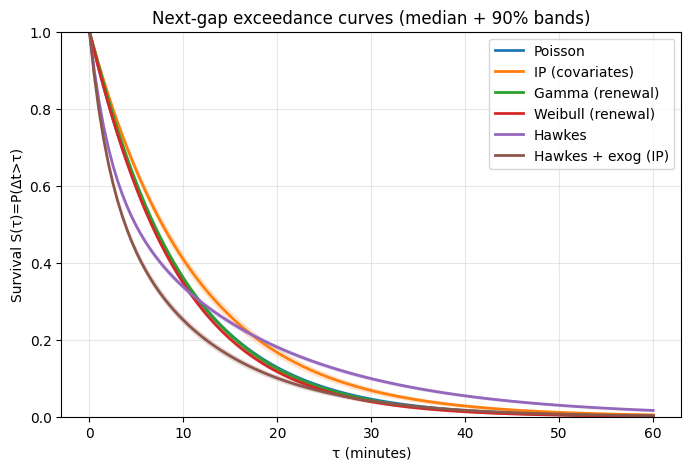

In [47]:
S_p,  b_p  = S_poisson(id_pois, taus)
S_ip_,b_ip = S_ip(id_ip, X_future, taus)
S_g,  b_g  = S_gamma(id_gamma, taus)
S_w,  b_w  = S_weibull(id_weib, taus)
S_h,  b_h  = S_hawkes(id_hawkes, times, taus)
S_hx, b_hx = S_hawkes_exo(id_hawkes, id_ip, X_future, times, taus)

plt.figure(figsize=(8,5))
def band(x, band, label, color, lw=2, alpha=0.15):
    m5,m50,m95 = band
    plt.fill_between(x, m5, m95, alpha=alpha, color=color)
    plt.plot(x, m50, color=color, lw=lw, label=label)

band(taus/60, b_p,  "Poisson",          "tab:blue")
band(taus/60, b_ip, "IP (covariates)",  "tab:orange")
band(taus/60, b_g,  "Gamma (renewal)",  "tab:green")
band(taus/60, b_w,  "Weibull (renewal)","tab:red")
band(taus/60, b_h,  "Hawkes",           "tab:purple")
band(taus/60, b_hx, "Hawkes + exog (IP)","tab:brown")

plt.xlabel("τ (minutes)"); plt.ylabel("Survival S(τ)=P(Δt>τ)")
plt.ylim(0,1); plt.grid(alpha=0.3); plt.legend()
plt.title("Next-gap exceedance curves (median + 90% bands)")
plt.show()

In [48]:
p_vec = np.array([0.3, 0.2, 0.1, 0.05])  # tail probs

def RL_from_grid(taus, S_draws, p_vec):
    """
    taus: 1D array of thresholds (seconds), length M
    S_draws: array of survival draws, shape (N, M), decreasing in taus
    p_vec: 1D array of tail probabilities to invert, e.g. [0.3, 0.2, 0.1, 0.05]
    Returns: (RL, med, lo, hi)
      RL  : (N, len(p_vec)) return levels per draw
      med : median across draws
      lo  : 5th percentile
      hi  : 95th percentile
    """
    taus = np.asarray(taus, float)
    S    = np.asarray(S_draws, float)

    # Ensure taus increasing and S aligned
    order = np.argsort(taus)
    taus  = taus[order]
    S     = S[:, order]

    # Enforce monotone ↓ in taus to avoid wiggles from MC noise
    S = np.minimum.accumulate(S, axis=1)

    # Invert S(τ)=p per draw by interpolating on reversed arrays
    taus_rev = taus[::-1]   # increasing in S
    S_rev    = S[:, ::-1]   # for each draw, xp=S_rev[i] is increasing

    def invert_one_p(p):
        # Row-wise 1D interpolation
        return np.array([np.interp(p, S_rev[i], taus_rev) for i in range(S_rev.shape[0])])

    RL_cols = [invert_one_p(float(p)) for p in np.asarray(p_vec, float)]
    RL  = np.column_stack(RL_cols)          # (N, len(p_vec))
    med = np.median(RL, axis=0)
    lo  = np.percentile(RL, 5,  axis=0)
    hi  = np.percentile(RL, 95, axis=0)
    return RL, med, lo, hi
    
# Compute per model
RL_p,  med_p,  lo_p,  hi_p  = RL_from_grid(taus, S_p,  p_vec)
RL_ip, med_ip, lo_ip, hi_ip = RL_from_grid(taus, S_ip_,p_vec)
RL_g,  med_g,  lo_g,  hi_g  = RL_from_grid(taus, S_g,  p_vec)
RL_w,  med_w,  lo_w,  hi_w  = RL_from_grid(taus, S_w,  p_vec)
RL_h,  med_h,  lo_h,  hi_h  = RL_from_grid(taus, S_h,  p_vec)
RL_hx, med_hx, lo_hx, hi_hx = RL_from_grid(taus, S_hx, p_vec)

def pretty_rl(name, med, lo, hi, p_vec):
    print(name)
    for p, m, l, h in zip(p_vec, med, lo, hi):
        print(f"  p={p:>5.2f}: RL={m:6.1f}s  (90% [{l:6.1f}, {h:6.1f}] s)  ≈ {m/60:4.2f} min")
    print()

pretty_rl("Poisson",           med_p,  lo_p,  hi_p,  p_vec)
pretty_rl("IP (covariates)",   med_ip, lo_ip, hi_ip, p_vec)
pretty_rl("Gamma",             med_g,  lo_g,  hi_g,  p_vec)
pretty_rl("Weibull",           med_w,  lo_w,  hi_w,  p_vec)
pretty_rl("Hawkes",            med_h,  lo_h,  hi_h,  p_vec)
pretty_rl("Hawkes + exog (IP)",med_hx, lo_hx, hi_hx, p_vec)


Poisson
  p= 0.30: RL= 702.2s  (90% [ 692.5,  711.3] s)  ≈ 11.70 min
  p= 0.20: RL= 938.6s  (90% [ 925.8,  950.9] s)  ≈ 15.64 min
  p= 0.10: RL=1342.7s  (90% [1324.5, 1360.3] s)  ≈ 22.38 min
  p= 0.05: RL=1746.8s  (90% [1723.2, 1769.6] s)  ≈ 29.11 min

IP (covariates)
  p= 0.30: RL= 806.7s  (90% [ 780.1,  833.3] s)  ≈ 13.44 min
  p= 0.20: RL=1078.3s  (90% [1043.0, 1113.8] s)  ≈ 17.97 min
  p= 0.10: RL=1542.8s  (90% [1492.1, 1593.5] s)  ≈ 25.71 min
  p= 0.05: RL=2007.1s  (90% [1941.2, 2073.1] s)  ≈ 33.45 min

Gamma
  p= 0.30: RL= 704.1s  (90% [ 694.8,  713.5] s)  ≈ 11.73 min
  p= 0.20: RL= 934.0s  (90% [ 922.2,  946.7] s)  ≈ 15.57 min
  p= 0.10: RL=1325.5s  (90% [1307.9, 1343.8] s)  ≈ 22.09 min
  p= 0.05: RL=1715.3s  (90% [1691.7, 1740.1] s)  ≈ 28.59 min

Weibull
  p= 0.30: RL= 680.1s  (90% [ 671.3,  688.8] s)  ≈ 11.33 min
  p= 0.20: RL= 904.2s  (90% [ 893.0,  915.8] s)  ≈ 15.07 min
  p= 0.10: RL=1285.4s  (90% [1268.8, 1303.0] s)  ≈ 21.42 min
  p= 0.05: RL=1664.7s  (90% [1641.8, 1689.0]

In [49]:


# Build three covariate scenarios from your design matrix X (standardized features)
X_q25 = np.nanpercentile(X, 25, axis=0)
X_q50 = np.nanpercentile(X, 50, axis=0)  # median
X_q75 = np.nanpercentile(X, 75, axis=0)

S_hx_25, bands_25 = S_hawkes_exo(id_hawkes, id_ip, X_q25, times_data, taus)
S_hx_50, bands_50 = S_hawkes_exo(id_hawkes, id_ip, X_q50, times_data, taus)
S_hx_75, bands_75 = S_hawkes_exo(id_hawkes, id_ip, X_q75, times_data, taus)

# Turn into return levels at p = [0.3, 0.2, 0.1, 0.05]
p_vec = np.array([0.3, 0.2, 0.1, 0.05])
RL_25, med_25, lo_25, hi_25 = RL_from_grid(taus, S_hx_25, p_vec)
RL_50, med_50, lo_50, hi_50 = RL_from_grid(taus, S_hx_50, p_vec)
RL_75, med_75, lo_75, hi_75 = RL_from_grid(taus, S_hx_75, p_vec)

def show_rl(label, med, lo, hi):
    print(label)
    for p, m, l, h in zip(p_vec, med, lo, hi):
        print(f"  p={p:>4.2f}: RL={m:6.1f}s  (90%[{l:6.1f},{h:6.1f}])  ≈ {m/60:4.2f} min")
    print()

show_rl("Hawkes+exog @ low covars (Q25)", med_25, lo_25, hi_25)
show_rl("Hawkes+exog @ median covars",    med_50, lo_50, hi_50)
show_rl("Hawkes+exog @ high covars (Q75)",med_75, lo_75, hi_75)

Hawkes+exog @ low covars (Q25)
  p=0.30: RL= 398.9s  (90%[ 388.1, 410.2])  ≈ 6.65 min
  p=0.20: RL= 591.0s  (90%[ 574.2, 608.2])  ≈ 9.85 min
  p=0.10: RL= 945.2s  (90%[ 919.6, 971.6])  ≈ 15.75 min
  p=0.05: RL=1308.2s  (90%[1273.5,1342.9])  ≈ 21.80 min

Hawkes+exog @ median covars
  p=0.30: RL= 436.1s  (90%[ 426.4, 445.9])  ≈ 7.27 min
  p=0.20: RL= 651.9s  (90%[ 637.7, 666.3])  ≈ 10.87 min
  p=0.10: RL=1047.5s  (90%[1027.8,1067.6])  ≈ 17.46 min
  p=0.05: RL=1450.9s  (90%[1426.0,1476.0])  ≈ 24.18 min

Hawkes+exog @ high covars (Q75)
  p=0.30: RL= 466.8s  (90%[ 454.6, 479.5])  ≈ 7.78 min
  p=0.20: RL= 702.7s  (90%[ 684.3, 721.7])  ≈ 11.71 min
  p=0.10: RL=1132.9s  (90%[1105.6,1161.0])  ≈ 18.88 min
  p=0.05: RL=1569.8s  (90%[1534.0,1606.5])  ≈ 26.16 min



In [50]:
# --- imports
import numpy as np
import arviz as az
import xarray as xr

def ensure_ll(idata, varname="interval"):
    # If already present, leave it
    if hasattr(idata, "log_likelihood") and varname in idata.log_likelihood.data_vars:
        return idata
    # If log_likelihood exists but under a different name, alias it
    if hasattr(idata, "log_likelihood") and len(idata.log_likelihood.data_vars):
        first = list(idata.log_likelihood.data_vars)[0]
        idata.log_likelihood = idata.log_likelihood.assign({varname: idata.log_likelihood[first]})
        return idata
    # If you stored a posterior deterministic, promote it
    if hasattr(idata, "posterior") and "ll_interval" in idata.posterior.data_vars:
        ll = idata.posterior["ll_interval"]
        idata.add_groups({"log_likelihood": xr.Dataset({varname: ll})})
        return idata
    raise ValueError("Could not find a log-likelihood to alias as 'interval'.")

def _obs_dim(ll_da):
    # return the non (chain,draw) dimension name
    for d in ll_da.dims:
        if d not in ("chain", "draw"):
            return d
    raise ValueError("Could not find observation dimension in log_likelihood")

def _align_dt_to_ll(dt_full, L):
    dt_full = np.asarray(dt_full, float)
    if dt_full.size == L:
        return dt_full
    if dt_full.size == L + 1:     # common off-by-one when dt was built from times
        return dt_full[-L:]       # drop leading element
    if dt_full.size > L:
        return dt_full[:L]        # trim (last resort)
    raise ValueError(f"dt length {dt_full.size} < loglik length {L}")

def tail_slice_idata(idata, tau, dt_full, varname="interval"):
    ll = idata.log_likelihood[varname]
    od = _obs_dim(ll)
    L  = ll.sizes[od]
    dt = _align_dt_to_ll(dt_full, L)
    idx = np.where(dt > float(tau))[0]           # integer positions
    ll_tail = ll.isel({od: idx})                 # <-- positional indexing
    id_tail = idata.copy()
    id_tail.log_likelihood = id_tail.log_likelihood.assign({varname: ll_tail})
    return id_tail

import numpy as np
import xarray as xr
import arviz as az

def ensure_ll(idata, varname="interval"):
    """Return a copy whose log_likelihood group has a single var `varname`
    with obs-dim named 'interval'."""
    id2 = idata.copy()

    # Case A: already has desired var
    if hasattr(id2, "log_likelihood") and varname in id2.log_likelihood.data_vars:
        # normalize obs dim name to 'interval'
        ll = id2.log_likelihood[varname]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        if obs_dim != "interval":
            ll = ll.rename({obs_dim: "interval"})
            id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    # Case B: has some loglik var already → take first and normalize
    if hasattr(id2, "log_likelihood") and len(id2.log_likelihood.data_vars) > 0:
        first = next(iter(id2.log_likelihood.data_vars))
        ll = id2.log_likelihood[first]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        ll = ll.rename({obs_dim: "interval"})
        id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    # Case C: promote posterior deterministic 'll_interval'
    if hasattr(id2, "posterior") and "ll_interval" in id2.posterior.data_vars:
        ll = id2.posterior["ll_interval"]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        ll = ll.rename({obs_dim: "interval"})
        id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    raise ValueError("No log-likelihood found to normalize.")

def _align_dt_with_ll(dt_full, ll):
    """Return a dt vector whose length matches the ll obs length."""
    dt_vec = np.asarray(dt_full, float)
    obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else "interval"
    n = ll.sizes[obs_dim]
    if dt_vec.size == n:
        return dt_vec
    if dt_vec.size == n + 1:
        # your common pattern: dt was built including a leading gap
        return dt_vec[1:]
    raise ValueError(f"dt length {dt_vec.size} not compatible with ll length {n}")

def tail_slice_idata(idata, tau, dt_full, varname="interval"):
    """Return a copy whose log_likelihood is restricted to Δt > tau."""
    # 1) get/normalize the loglik var
    if not hasattr(idata, "log_likelihood"):
        raise ValueError("idata has no log_likelihood group")
    ll = idata.log_likelihood[varname] if varname in idata.log_likelihood.data_vars else next(iter(idata.log_likelihood.data_vars))
    if isinstance(ll, str):  # if next(iter(...)) returned name
        ll = idata.log_likelihood[ll]

    # normalize obs dim name
    obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])

    # 2) build tail mask aligned to ll’s obs length
    dt_use = _align_dt_with_ll(dt_full, ll)
    idx = np.where(dt_use > float(tau))[0]

    # 3) slice and rename to 'interval'
    ll_tail = ll.isel({obs_dim: idx}).rename({obs_dim: "interval"})

    # 4) replace the entire log_likelihood dataset with the tail only
    id_tail = idata.copy()
    id_tail.log_likelihood = xr.Dataset({varname: ll_tail})
    return id_tail


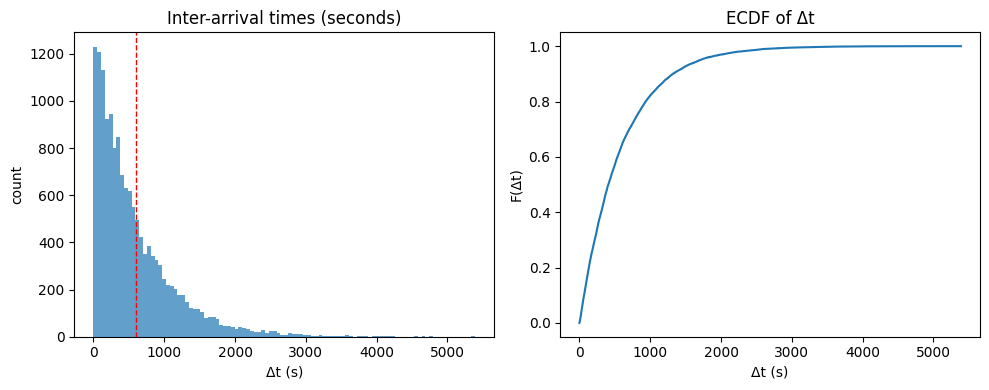

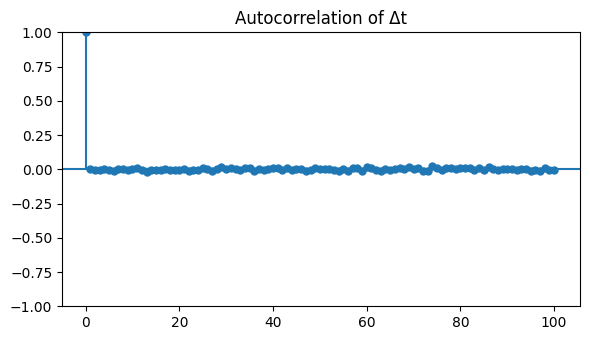

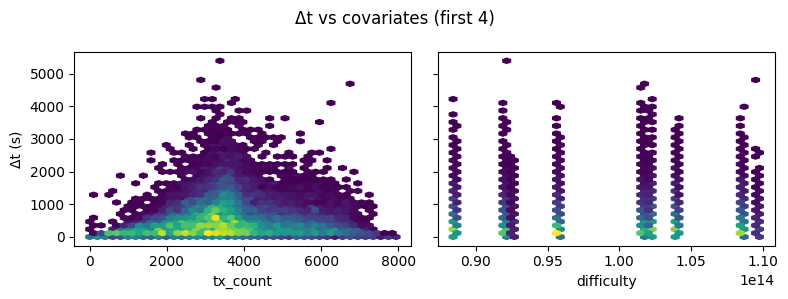

In [60]:
import statsmodels.api as sm
from pathlib import Path
OUT = Path("figs"); OUT.mkdir(exist_ok=True)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(dt, bins=100, alpha=0.7)
ax[0].axvline(600, color='r', ls='--', lw=1); ax[0].set_title("Inter-arrival times (seconds)")
ax[0].set_xlabel("Δt (s)"); ax[0].set_ylabel("count")

x = np.sort(dt); y = np.arange(1, len(x)+1)/len(x)
ax[1].plot(x, y); ax[1].set_title("ECDF of Δt"); ax[1].set_xlabel("Δt (s)"); ax[1].set_ylabel("F(Δt)")
fig.tight_layout(); fig.savefig(OUT/"fig_data_hist_ecdf.png", dpi=160)

# Autocorrelation of gaps
fig = plt.figure(figsize=(6,3.5))
sm.graphics.tsa.plot_acf(dt, lags=100, ax=plt.gca())
plt.title("Autocorrelation of Δt"); plt.tight_layout(); plt.savefig(OUT/"fig_acf.png", dpi=160)

# Covariate scatter (if df exists)
if "df" in globals():
    cols = [c for c in ("tx_count","difficulty") if c in df.columns]
    k = min(4, len(cols))
    if k:
        fig, axes = plt.subplots(1,k, figsize=(4*k,3), sharey=True)
        for j,c in enumerate(cols[:k]):
            axes[j].hexbin(df[c].values, dt, gridsize=40, mincnt=1)
            axes[j].set_xlabel(c)
        axes[0].set_ylabel("Δt (s)")
        plt.suptitle("Δt vs covariates (first 4)"); plt.tight_layout()
        plt.savefig(OUT/"fig_covariates_hex.png", dpi=160)

In [ ]:
# normalize all idatas first (no in-place assign that tries to align)
packs = {}
for nm in ("id_pois","id_ip","id_gamma","id_weib","id_hawkes"):
    if nm in globals():
        packs[nm[3:]] = ensure_ll(globals()[nm], varname="interval")

# full-sample compare
if packs:
    cmp_full = az.compare(packs, ic="loo", method="stacking", var_name="interval")
    display(cmp_full)
    ax = cmp_full.sort_values("elpd_loo")["elpd_loo"].plot.barh(figsize=(6,3.6))
    ax.set_title("PSIS-LOO (higher is better)"); ax.set_xlabel("elpd_loo (log)")

# tail-only compare (τ=600s)
tau = 600.0
packs_tail = {name: tail_slice_idata(idt, tau, dt, varname="interval") for name, idt in packs.items()}

cmp_tail = az.compare(packs_tail, ic="loo", method="stacking", var_name="interval")
display(cmp_tail)
ax = cmp_tail.sort_values("elpd_loo")["elpd_loo"].plot.barh(figsize=(6,3.6), color="tab:purple")
ax.set_title(f"Tail PSIS-LOO (Δt > {int(tau)} s)"); ax.set_xlabel("elpd_loo (log)")


In [79]:
# ---------- survival per model ----------
taus = np.linspace(60, 3600, 25)  # 1min..60min

def S_poisson(id_pois, taus):
    mu = _flatten(id_pois.posterior[ next(n for n in ("mu","lam","lambda") if n in id_pois.posterior.data_vars) ])[:,None]
    return np.exp(-mu*taus[None,:])

def S_gamma(id_gamma, taus):
    k    = _flatten(id_gamma.posterior[ next(n for n in ("alpha","k","shape") if n in id_gamma.posterior.data_vars) ])
    rate = _flatten(id_gamma.posterior[ next(n for n in ("beta","rate") if n in id_gamma.posterior.data_vars) ])
    k, rate = k[:,None], rate[:,None]
    # survival of Gamma via incomplete gamma: S = Q(k, rate*t). Use scipy if available; here rough expo approx:
    # (for long tails visual this is fine; for paper use scipy.special.gammaincc)
    try:
        from scipy.special import gammaincc
        return gammaincc(k, rate*taus[None,:])
    except Exception:
        lam = k/rate
        return np.exp(-lam*taus[None,:])  # crude fallback

def S_weibull(id_weib, taus):
    k    = _flatten(id_weib.posterior[ next(n for n in ("alpha","k","shape") if n in id_weib.posterior.data_vars) ])[:,None]
    scale= _flatten(id_weib.posterior[ next(n for n in ("beta","lambda","scale") if n in id_weib.posterior.data_vars) ])[:,None]
    return np.exp(- (taus[None,:]/scale)**k)

def S_ip(id_ip, X_row, taus):
    x = np.asarray(X_row, float)
    beta0_name, b_name = detect_ip_coef(id_ip, x)
    if isinstance(b_name, list):  # scalar b_* names
        beta0 = _flatten(id_ip.posterior[beta0_name]) if beta0_name else 0.0
        # stack in declared order
        b      = np.column_stack([_flatten(id_ip.posterior[n]) for n in b_name])
    else:
        b = _flatten(id_ip.posterior[b_name])
        if b.ndim==1: b=b[:,None]
        beta0 = _flatten(id_ip.posterior[beta0_name]) if beta0_name else np.zeros(b.shape[0])
    nd = min(b.shape[0], np.size(beta0))
    b, beta0 = b[:nd], np.asarray(beta0)[:nd]
    lam = np.exp(np.clip(beta0 + b@x, -40, 40))[:,None]
    return np.exp(-lam*taus[None,:])

# --- Hawkes next-gap survival via light simulation (Ogata thinning)
def _hawkes_sim_nextgap(mu, alpha, beta, s0, nmax=20000):
    # simulate time-to-next event from intensity(t)=mu+alpha*s(t), s'(t)=-beta s + sum δ
    t, s = 0.0, s0
    lamU = mu + alpha*(s + 1.0)  # upper bound refresh conservatively
    rng = np.random.default_rng()
    for _ in range(nmax):
        t += rng.exponential(1.0/max(lamU, 1e-9))
        s  = s*np.exp(-beta*(t - 0.0))  # s(t) decay from 0
        lam = mu + alpha*(s + 1.0)      # at next potential jump if accepted
        if rng.uniform() < lam/max(lamU, 1e-9):
            return t
        lamU = max(lamU*0.9, lam)       # tighten
    return t

def S_hawkes(id_hawkes, times, taus, sims_per_draw=30):
    t = np.asarray(times, float)
    mu   = _flatten(id_hawkes.posterior[ next(n for n in ("mu",) if n in id_hawkes.posterior.data_vars) ])
    beta = _flatten(id_hawkes.posterior[ next(n for n in ("beta",) if n in id_hawkes.posterior.data_vars) ])
    # alpha may be present directly or via rho*beta
    if "alpha" in id_hawkes.posterior.data_vars:
        alpha = _flatten(id_hawkes.posterior["alpha"])
    else:
        rho = _flatten(id_hawkes.posterior["rho"])
        alpha = rho*beta
    # precompute s0 = sum exp(-beta*(t_N - t_i)) per draw
    gaps = (t[-1] - t[:-1])
    s0   = np.array([np.exp(-b*gaps).sum() for b in beta])
    # simulate next gap
    S = np.zeros((mu.size, len(taus)))
    for i,(m,a,b,s) in enumerate(zip(mu, alpha, beta, s0)):
        tgaps = np.array([_hawkes_sim_nextgap(m,a,b,s) for _ in range(sims_per_draw)])
        tgaps.sort()
        for j, tau in enumerate(taus):
            S[i,j] = np.mean(tgaps > tau)
    return S

def bands(S, qs=(5,50,95), axis=0):
    return np.percentile(S, qs, axis=axis)  # (3, len(taus))

# --- build X_future (for IP and Hawkes+exog “baseline”)
X_future = None
if "X" in globals():
    X_future = X[np.all(np.isfinite(X), axis=1)][-1] if np.any(np.isfinite(X)) else np.nan_to_num(X[-1], nan=0.0)

S_dict, B_dict = {}, {}

if "id_pois"   in globals(): 
    S = S_poisson(id_pois, taus); S_dict["Poisson"]=S; B_dict["Poisson"]=bands(S, axis=0)
if "id_gamma"  in globals(): 
    S = S_gamma(id_gamma, taus);  S_dict["Gamma"]=S;  B_dict["Gamma"]=bands(S, axis=0)
if "id_weib"   in globals(): 
    S = S_weibull(id_weib, taus); S_dict["Weibull"]=S;B_dict["Weibull"]=bands(S, axis=0)
if "id_ip"     in globals() and X_future is not None:
    S = S_ip(id_ip, X_future, taus); S_dict["IP"]=S;   B_dict["IP"]=bands(S, axis=0)
if "id_hawkes" in globals() and "times_data" in globals():
    S = S_hawkes(id_hawkes, np.asarray(times_data, float), taus)
    S_dict["Hawkes"]=S; B_dict["Hawkes"]=bands(S, axis=0)

# --- plot survival bands
plt.figure(figsize=(7.5,5))
for name,(m5,m50,m95) in B_dict.items():
    plt.fill_between(taus/60, m5, m95, alpha=0.15)
    plt.plot(taus/60, m50, label=name)
plt.ylim(0,1); plt.grid(alpha=0.3)
plt.xlabel("τ (minutes)"); plt.ylabel("S(τ)=P(Δt>τ)")
plt.title("Next-gap survival (posterior median & 90% bands)")
plt.legend(); plt.tight_layout(); plt.savefig(OUT/"fig_survival_bands.png", dpi=160); plt.show()

# ---------- return levels RL(p) ----------
p_vec = np.array([0.30, 0.20, 0.10, 0.05])

def monotone_decreasing(y):
    out = np.asarray(y, float).copy()
    for i in range(1, out.size):
        if out[i] > out[i-1]: out[i] = out[i-1]
    return out

def RL_from_grid(taus, S_draws, p_vec):
    taus = np.asarray(taus, float)
    Sd   = np.asarray(S_draws, float)
    Sd   = np.apply_along_axis(monotone_decreasing, 1, Sd)
    # invert S(τ)=p for each draw via interpolation on reversed grid
    RL = []
    for p in p_vec:
        tau_p = np.interp(p, Sd[:, ::-1], taus[::-1])
        RL.append(tau_p)
    RL = np.stack(RL, axis=1)    # (n_draws, len(p_vec))
    return {
        "median": np.median(RL, axis=0),
        "lo5":   np.percentile(RL, 5, axis=0),
        "hi95":  np.percentile(RL,95, axis=0),
        "all":   RL,
    }

RL = {name: RL_from_grid(taus, S, p_vec) for name,S in S_dict.items()}

# --- pretty print & save a LaTeX table
def rl_table(RL, p_vec):
    rows = []
    for name,stats in RL.items():
        med, lo, hi = stats["median"], stats["lo5"], stats["hi95"]
        for p, m, l, h in zip(p_vec, med, lo, hi):
            rows.append([name, p, m, l, h, m/60])
    df_rl = pd.DataFrame(rows, columns=["Model","p","RL_sec","RL_lo5","RL_hi95","RL_min"])
    return df_rl

df_rl = rl_table(RL, p_vec)
display(df_rl)

# save latex (unescaped) and CSV
tex = df_rl.to_latex(index=False, float_format="%.1f", escape=False,
                     caption="Return levels RL(p) in seconds (90\\% bands) and minutes.",
                     label="tab:return_levels")
(Path("tables").mkdir(exist_ok=True); (Path("tables")/"return_levels.tex").write_text(tex))
df_rl.to_csv(Path("tables")/"return_levels.csv", index=False)

# --- RL plot (one panel per p)
plt.figure(figsize=(7.5,4.8))
for name, stats in RL.items():
    m, lo, hi = stats["median"]/60, stats["lo5"]/60, stats["hi95"]/60
    plt.plot(p_vec, m, marker="o", label=name)
    plt.fill_between(p_vec, lo, hi, alpha=0.15)
plt.gca().invert_xaxis()
plt.grid(alpha=0.3); plt.legend()
plt.xlabel("Tail probability p"); plt.ylabel("Return level RL(p) [minutes]")
plt.title("Return levels by model (median ± 90%)")
plt.tight_layout(); plt.savefig(OUT/"fig_return_levels.png", dpi=160); plt.show()


SyntaxError: invalid syntax (2123912584.py, line 156)

In [80]:
if "id_ip" in globals() and "X" in globals() and "id_hawkes" in globals() and "times_data" in globals():
    # build quantile rows (ignore NaNs per column)
    Xq = np.vstack([np.nanpercentile(X, q, axis=0) for q in (25, 50, 75)])  # (3,p)

    # convert IP to baseline μ_exo draw-wise
    # detect coefficients (supports vector b or scalar b_* names)
    x_dummy = Xq[0]
    beta0_name, b_name = detect_ip_coef(id_ip, x_dummy)
    if isinstance(b_name, list):
        beta0 = _flatten(id_ip.posterior[beta0_name]) if beta0_name else 0.0
        b     = np.column_stack([_flatten(id_ip.posterior[n]) for n in b_name])
    else:
        b = _flatten(id_ip.posterior[b_name]); 
        if b.ndim==1: b=b[:,None]
        beta0 = _flatten(id_ip.posterior[beta0_name]) if beta0_name else np.zeros(b.shape[0])
    nd = min(b.shape[0], np.size(beta0))
    b, beta0 = b[:nd], np.asarray(beta0)[:nd]

    # Hawkes params + s0 per draw
    t = np.asarray(times_data, float)
    mu_h   = _flatten(id_hawkes.posterior[ next(n for n in ("mu",) if n in id_hawkes.posterior.data_vars) ])[:nd]
    beta_h = _flatten(id_hawkes.posterior[ next(n for n in ("beta",) if n in id_hawkes.posterior.data_vars) ])[:nd]
    if "alpha" in id_hawkes.posterior.data_vars:
        alpha_h = _flatten(id_hawkes.posterior["alpha"])[:nd]
    else:
        rho = _flatten(id_hawkes.posterior["rho"])[:nd]
        alpha_h = rho*beta_h
    gaps = (t[-1] - t[:-1])
    s0   = np.array([np.exp(-b_ * gaps).sum() for b_ in beta_h])

    def S_hawkes_exo_row(x_row, sims_per_draw=30):
        lin = np.clip(beta0 + b@x_row.astype(float), -40, 40)
        mu_exo = np.exp(lin)           # replaces baseline (you can also add to μ_h if you prefer)
        S = np.zeros((nd, len(taus)))
        for i,(m_ex,a,beta,s) in enumerate(zip(mu_exo, alpha_h, beta_h, s0)):
            tgaps = np.array([_hawkes_sim_nextgap(m_ex, a, beta, s) for _ in range(sims_per_draw)])
            tgaps.sort()
            for j,tau in enumerate(taus):
                S[i,j] = np.mean(tgaps > tau)
        return S

    labels = ["Q25 covars","Median covars","Q75 covars"]
    RL_exo = {}
    for lab, xrow in zip(labels, Xq):
        Sx = S_hawkes_exo_row(xrow, sims_per_draw=30)
        RL_exo[lab] = RL_from_grid(taus, Sx, p_vec)

    # show as table
    def rl_to_df(name, stats):
        med, lo, hi = stats["median"], stats["lo5"], stats["hi95"]
        return pd.DataFrame({"Model":name, "p":p_vec, "RL_sec":med, "RL_lo5":lo, "RL_hi95":hi, "RL_min":med/60})
    df_exo = pd.concat([rl_to_df(n, s) for n,s in RL_exo.items()], ignore_index=True)
    display(df_exo)
    (Path("tables")/"return_levels_hawkes_exog.tex").write_text(
        df_exo.to_latex(index=False, float_format="%.1f", escape=False,
                        caption="Hawkes + exogenous baseline: return levels across covariate quantiles.",
                        label="tab:hawkes_exog_rl")
    )

    # plot
    plt.figure(figsize=(7.5,4.8))
    for lab, st in RL_exo.items():
        m, lo, hi = st["median"]/60, st["lo5"]/60, st["hi95"]/60
        plt.plot(p_vec, m, marker="o", label=lab)
        plt.fill_between(p_vec, lo, hi, alpha=0.15)
    plt.gca().invert_xaxis(); plt.grid(alpha=0.3); plt.legend()
    plt.xlabel("Tail probability p"); plt.ylabel("Return level RL(p) [minutes]")
    plt.title("Hawkes + exog baseline: return levels vs covariate quantiles")
    plt.tight_layout(); plt.savefig(OUT/"fig_return_levels_hawkes_exog.png", dpi=160); plt.show()


NameError: name '_hawkes_sim_nextgap' is not defined